In [1]:
import os
home_url = os.getcwd()

In [2]:
home_url

'/notebooks/Downloads/MSADA/Preprocessing/DSADS'

In [3]:
import sys
sys.path.append(home_url+'/../../Packages/Utils/')
sys.path.append(home_url+'/../../Packages/Model/')

In [4]:
from Visualization import plot_activity
from DataPreprocess import standardization_and_normalization

import matplotlib as plt
import pandas as pd
import os
import numpy as np
import math
import csv
import pickle
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
torch.manual_seed(10)
np.random.seed(10)

In [ ]:
url = home_url+ "/../../Dataset/DSADS/data"
item = ["train","valid","test"]
person_list = ["User1","User2","User3","User4","User5","User6","User7","User8"]
activity = ['a00','a01','a02','a03','a04','a05','a06','a07','a08','a09','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19']
torso_index = [0,1,2,"Person", "Activity"]
right_arm_index = [9,10,11,"Person", "Activity"]
left_arm_index = [18,19,20,"Person", "Activity"]
right_leg_index = [27,28,29,"Person", "Activity"]
left_leg_index = [36,37,38,"Person", "Activity"]
body_part_index = [torso_index,right_arm_index,left_arm_index,right_leg_index,left_leg_index]
position_array = ["TORSO","RA","LA","RL","LL"]
column_name = ['AccX','AccY','AccZ','Person','Activity']

In [6]:
win_size=128
overlap = 0.90
step_size=int(win_size*overlap)
train_percentage = 0.6
valid_percentage = 0.2
activity_num = 10
search_list = []
user = {}
source1 = 0
source2 = 1
target = 2
selected_user = 3

In [25]:
home_url

'/notebooks/Downloads/MSADA/Preprocessing/DSADS'

In [26]:
folder_name = str(activity_num)+ " Activity"+"_Window "+str(win_size)+ "_Overlap "+str(overlap)
save_path = home_url+"/Data Files/"+folder_name+"/"

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [11]:
activity_list = [ "standing", "lying-back", "ascending", "walking-parking-lot", "treadmill-running", "stepper-exercise", "cross-trainer-exercise", "rowing", "jumping",  "playing-basketball"]

In [12]:
def filter_activity():
    global activity_dict
    activity_to_level = {"sitting":1, "standing":2, "lying-back":3, "lying-right":4, "ascending":5, "descending":6, \
                 "standing-in-elevator":7, "moving-in-elevator":8, "walking-parking-lot":9, \
                "treadmill-walking-slow":10, "trademill-inclined-walking":11, "treadmill-running":12, "stepper-exercise":13, \
                "cross-trainer-exercise":14, "exercise-bike-cycling-horizontal":15, "exercise-bike-cycling-vertical":16, \
                "rowing":17, "jumping":18, "playing-basketball":19}
    
    for idx in range(0,len(activity_list)):
        search_list.append(activity_to_level[activity_list[idx]])

In [13]:
filter_activity()

In [14]:
search_list

[2, 3, 5, 9, 12, 13, 14, 17, 18, 19]

In [15]:
level_to_activity = {1:"sitting", 2:"standing", 3:"lying-back", 4:"lying-right", 5:"ascending", 6:"descending", \
                 7:"standing-in-elevator", 8:"moving-in-elevator", 9:"walking-parking-lot", \
                10:"treadmill-walking-slow", 11:"trademill-inclined-walking", 12:"treadmill-running", 13:"stepper-exercise", \
                14:"cross-trainer-exercise", 15:"exercise-bike-cycling-horizontal", 16:"exercise-bike-cycling-vertical", \
                17:"rowing", 18:"jumping", 19:"playing-basketball"}

# Dataset File Structure and Information
    - POSITION: COLUMN
    - Torso: 1-9
    - RA: 10-18
    - LA: 19-27
    - RL: 28-36
    - LL: 37-45
    
    ### Map Activities into Labels
    - a1 = Sitting = 0
    - a2 = Standing = 1
    - a3 and a4 = Lying back and right = 2
    - a9 = walking = 3
    - a10 = walking trademill flat 10km/h = 3
    - a11 = walking trademill 15 deg inclined = 3
    - a12 = running on trademill 8km/h = 4
    - a5 = ascending stairs = 5
    - a6 = descending stairs = 6

# Merge Files - Merge all the 60 files for a person for each activity
    - For all 8 users
    - Total collection time for each activity - 5 mins 
        - From each minute 12 data segments
        - For 5 mins 60 segments in total

In [16]:
def merge_datafiles():
    for person_id in range(1,9):
        for activity_id in range(len(search_list)):    
            for x in range(1,61):
                if x == 1:
                    # To create an initial dataframe for the very first activity
                    if activity_id == 0:
                        s = 's0'+str(x)
                        dataframe = pd.read_csv(url+'/'+activity[search_list[activity_id]]+'/p'+str(person_id)+'/'+s+'.txt', sep=",", header=None)
                    else:
                        s = 's0'+str(x)
                        patial_dataframe = pd.read_csv(url+'/'+activity[search_list[activity_id]]+'/p'+str(person_id)+'/'+s+'.txt', sep=",", header=None)
                        dataframe =dataframe.append(patial_dataframe, ignore_index=True, sort=False)
                elif x < 10:
                    s = 's0'+str(x)
                    patial_dataframe = pd.read_csv(url+'/'+activity[search_list[activity_id]]+'/p'+str(person_id)+'/'+s+'.txt', sep=",", header=None)
                    dataframe =dataframe.append(patial_dataframe, ignore_index=True, sort=False)
                else:
                    s = 's'+str(x)
                    patial_dataframe = pd.read_csv(url+'/'+activity[search_list[activity_id]]+'/p'+str(person_id)+'/'+s+'.txt', sep=",", header=None)
                    dataframe =dataframe.append(patial_dataframe, ignore_index=True, sort=False)

            dataframe.loc[:, 'Person'] = person_id
            dataframe.loc[activity_id*7500:activity_id*7500+7499, 'Activity'] = search_list[activity_id]
            dataframe.reset_index(drop=True, inplace=True)
        user[person_id] = dataframe 

##### Combine 60 files for each activity under each user

In [17]:
merge_datafiles()

In [18]:
# user[2].head()
# user[2].shape
# user[2]['Activity'].unique()

# Extract Each Users Position-wise Data For All Activity, Standardize

In [19]:
normalized_datafiles = {}

In [20]:
def standardization_datafiles():
    global column_name
    for person_id in range(1,9):
        
        # Replace the activity with highest number with 0. 
        # It helps to re-order the activity ids starting from 0
        # The activity ids are multiplied by 100 so that it does not conflict during replacement
        user[person_id].loc[:].replace({'Activity' : {19:0}}, inplace = True)
        user[person_id].loc[:]['Activity'] *= 100
        convert_activity_list = user[person_id]['Activity'].unique()
        
        for replaced_activity in range(len(convert_activity_list)-1, -1, -1):
            user[person_id].loc[:].replace({'Activity' : {convert_activity_list[replaced_activity]:replaced_activity}}, inplace = True)
     
    for person_id in range(1,9):
        for position_id in range(0,5):
            index = person_id*10 + position_id
#             print(str(index))
            if position_id == 0:
                normalized_datafiles[index] = user[person_id][torso_index].copy()
            elif position_id == 1:
                normalized_datafiles[index] = user[person_id][right_arm_index].copy()
            elif position_id == 2:
                normalized_datafiles[index] = user[person_id][left_arm_index].copy()
            elif position_id == 3:
                normalized_datafiles[index] = user[person_id][right_leg_index].copy()
            elif position_id == 4:
                normalized_datafiles[index] = user[person_id][left_leg_index].copy()
            
            normalized_datafiles[index].columns = column_name
            person_gt = np.array(normalized_datafiles[index]['Person'])
            activity_gt = np.array(normalized_datafiles[index]['Activity'])
            
            normalized_datafiles[index].drop(['Person','Activity'], axis=1, inplace=True)
            save_column_name = normalized_datafiles[index].columns
            
            np_scaled = standardization_and_normalization(normalized_datafiles[index])
            normalized_datafiles[index] = pd.DataFrame(np_scaled, columns=save_column_name)
            
            normalized_datafiles[index]["Person"] = person_gt
            normalized_datafiles[index]["Activity"] = activity_gt

In [21]:
standardization_datafiles()

In [22]:
# for person_id in range(1,9):
#         for position_id in range(0,5):
#             index = person_id*10 + position_id
#             normalized_datafiles[index].columns = column_name
#             print(str(normalized_datafiles[index]['Activity'].unique()))

In [28]:
# normalized_datafiles[10].head()

In [29]:
def data_file_generation():
    for person_id in range(1,9):
        for position_id in range(0,5):
            index = person_id*10 + position_id
            
            train_dataframe = pd.DataFrame(columns=['AccX', 'AccY', 'AccZ', 'Person', 'Activity'])
            valid_dataframe = pd.DataFrame(columns=['AccX', 'AccY', 'AccZ', 'Person', 'Activity'])
            test_dataframe = pd.DataFrame(columns=['AccX', 'AccY', 'AccZ', 'Person', 'Activity'])
            
            total_activity = len(np.unique(normalized_datafiles[index]['Activity']))
            print("User: "+ str(person_id) +" Label Space: "+ str(total_activity))
            
            for activity_index in range(0,total_activity):
                dataframe = normalized_datafiles[index][(normalized_datafiles[index]["Activity"] == activity_index)].copy()
                
                train_upto = int(dataframe.shape[0]*train_percentage)    
                valid_upto = int(dataframe.shape[0]*valid_percentage) 
                
                train = dataframe[0:train_upto].copy()
                valid = dataframe[train_upto+1 : train_upto+valid_upto].copy()
                test = dataframe[train_upto+valid_upto+1 : dataframe.shape[0]].copy() 
                
                train_dataframe = train_dataframe.append(train, ignore_index=True, sort=False)
                valid_dataframe = valid_dataframe.append(valid, ignore_index=True, sort=False)
                test_dataframe = test_dataframe.append(test, ignore_index=True, sort=False)
            
            train_dataframe.to_csv (save_path+'User'+str(person_id)+'_'+position_array[position_id]+'_train'+'.csv', index = None, header=True)
            valid_dataframe.to_csv (save_path+'User'+str(person_id)+'_'+position_array[position_id]+'_valid'+'.csv', index = None, header=True)
            test_dataframe.to_csv (save_path+'User'+str(person_id)+'_'+position_array[position_id]+'_test'+'.csv', index = None, header=True)

In [31]:
# save_path

In [32]:
data_file_generation()

User: 1 Label Space: 10
User: 1 Label Space: 10
User: 1 Label Space: 10
User: 1 Label Space: 10
User: 1 Label Space: 10
User: 2 Label Space: 10
User: 2 Label Space: 10
User: 2 Label Space: 10
User: 2 Label Space: 10
User: 2 Label Space: 10
User: 3 Label Space: 10
User: 3 Label Space: 10
User: 3 Label Space: 10
User: 3 Label Space: 10
User: 3 Label Space: 10
User: 4 Label Space: 10
User: 4 Label Space: 10
User: 4 Label Space: 10
User: 4 Label Space: 10
User: 4 Label Space: 10
User: 5 Label Space: 10
User: 5 Label Space: 10
User: 5 Label Space: 10
User: 5 Label Space: 10
User: 5 Label Space: 10
User: 6 Label Space: 10
User: 6 Label Space: 10
User: 6 Label Space: 10
User: 6 Label Space: 10
User: 6 Label Space: 10
User: 7 Label Space: 10
User: 7 Label Space: 10
User: 7 Label Space: 10
User: 7 Label Space: 10
User: 7 Label Space: 10
User: 8 Label Space: 10
User: 8 Label Space: 10
User: 8 Label Space: 10
User: 8 Label Space: 10
User: 8 Label Space: 10


# Windowing Testing

In [33]:
s1_train = []
s2_train = []
t_train = []

s1_gt_train = []
s2_gt_train = []
t_gt_train = []

In [34]:
s1_valid = []
s2_valid = []
t_valid = []

s1_gt_valid = []
s2_gt_valid = []
t_gt_valid = []

In [35]:
s1_test = []
s2_test = []
t_test = []

s1_gt_test = []
s2_gt_test = []
t_gt_test = []

In [36]:
AXIS = 3
FROM = 0
TO = FROM+3
START = TO
END = 5

In [37]:
def calculate_window(dataframe, data, data_gt):
    len_df = dataframe.shape[0]
    narray = dataframe.values
    for i in range(0, len_df, step_size):
        window = narray[i:i+win_size, FROM:TO]

        if window.shape[0] != win_size:
            continue
        else:
            reshaped_window = window.reshape(1,win_size,1,AXIS)
            gt = np.bincount(narray[i:i+win_size,START:END].astype(int).ravel()).argmax()
            
            data.append(reshaped_window)
            data_gt.append(gt)

In [38]:
data_source = {"source1":source1, "source2": source2, "target":target}

In [39]:
for key in data_source:
        for split_index in range(0,3):
            file_name = person_list[selected_user-1] + "_" + position_array[data_source[key]]+'_'+item[split_index]
            print(file_name)
            
            df = pd.read_csv(save_path+file_name+'.csv', sep=",")   
            
            if key == "source1":
                if split_index == 0:
                    calculate_window(df, s1_train, s1_gt_train)
                elif split_index == 1:
                    calculate_window(df, s1_valid, s1_gt_valid)
                elif split_index == 2:
                    calculate_window(df, s1_test, s1_gt_test)
            elif key == "source2":
                if split_index == 0:
                    calculate_window(df, s2_train, s2_gt_train)
                elif split_index == 1:
                    calculate_window(df, s2_valid, s2_gt_valid)
                elif split_index == 2:
                    calculate_window(df, s2_test, s2_gt_test)
            elif key == "target":
                if split_index == 0:
                    calculate_window(df, t_train, t_gt_train)
                elif split_index == 1:
                    calculate_window(df, t_valid, t_gt_valid)
                elif split_index == 2:
                    calculate_window(df, t_test, t_gt_test)

User3_TORSO_train
User3_TORSO_valid
User3_TORSO_test
User3_RA_train
User3_RA_valid
User3_RA_test
User3_LA_train
User3_LA_valid
User3_LA_test


# Dataset Visualization

In [40]:
def plot_activity(df, position='Default', save = False, save_url = ""):
    data = df[['AccX', 'AccY','AccZ']][:df.shape[0]]

    axis = data.plot(subplots=True, figsize=(16, 12), title=position)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
#         if save == True:
#             ax.figure.savefig(save_url+'.png')

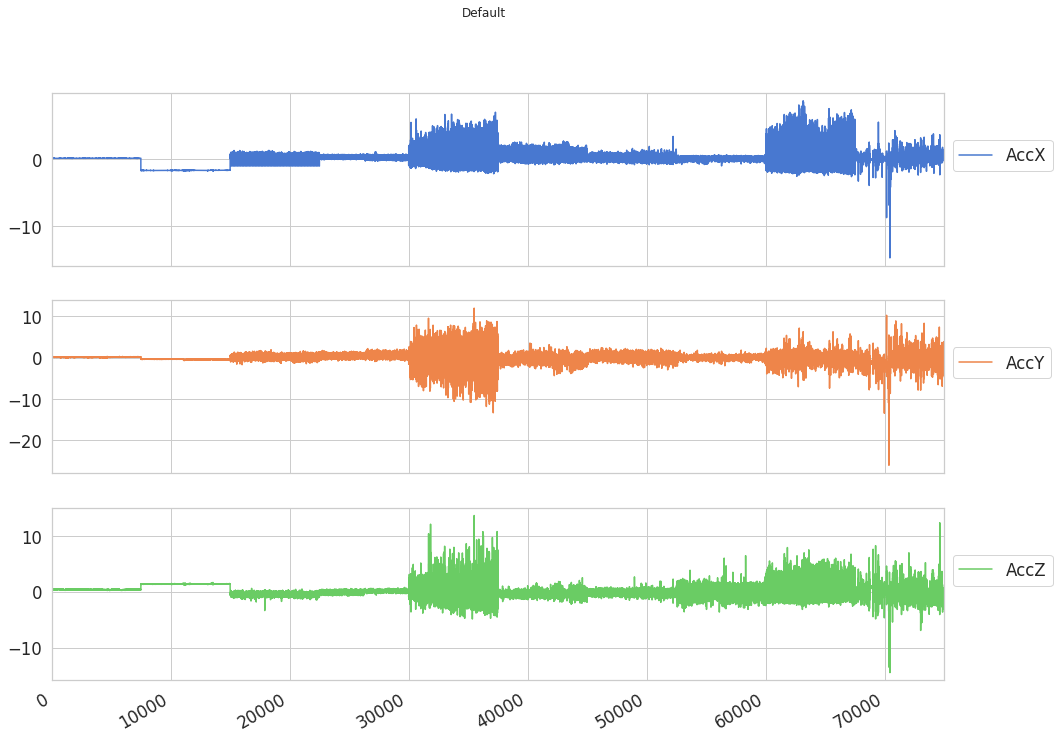

In [41]:
plot_activity(normalized_datafiles[10])